In [2]:
import sys
import os

In [3]:
import datetime

In [4]:
import numpy
import scipy
import pandas

In [5]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

In [6]:
sys.path.append(os.path.join(os.path.abspath(os.path.join('../..')), 'src'))

In [7]:
import utils
import mysql_utils
import events_merge
import spectral_partition

In [14]:
from importlib import reload

In [25]:
reload(events_merge)

<module 'events_merge' from '/home/immersinn/gits/rssfeed_link_collector/src/events_merge.py'>

## Prelims

In [8]:
start_date = '2017-02-01'

### Get MySQL Connection, Cursor

In [204]:
cnx = mysql_utils.getCnx()

In [205]:
cur = mysql_utils.getCur(cnx)

## Generate Slices

In [66]:
docids, tslices = events_merge.get_slices(cur, start_date=start_date, n_segments=5)

In [67]:
docids.keys()

dict_keys([0, 1, 2, 3, 4])

## Create Simple "Big Graph"

In [68]:
connected_pairs = [(i,i+1) for i in range(len(docids)-1)]
connected_pairs

[(0, 1), (1, 2), (2, 3), (3, 4)]

In [69]:
bg, idmapper = events_merge.merge_slices_simple(docids, tslices, connected_pairs)

In [70]:
bg = bg.tocsr()

In [71]:
bg.shape

(587, 587)

In [72]:
# Density of matrix
bg.nnz / bg.shape[0] ** 2

0.145648621901564

In [73]:
cci = numpy.where(bg.sum(axis=1) > 0)[0]

In [74]:
bg_cci = bg[cci,:][:, cci]

In [192]:
bg_cci.shape

(587, 587)

In [201]:
candidates = [1,5,3]
v = set(bg_cci[candidates,:].nonzero()[1])

In [202]:
candidates = v.update(candidates)

In [203]:
candidates

## Cluster

In [134]:
def reorder_history_nodes(hhh):
    """
    <Stuffs here>
    """
    order_hist = []
    n_nodes, n_levels = hhh.shape
    
    prev_grps = [0]
    for lev in range(n_levels):
        if len(prev_grps)==1:
            new_order = numpy.argsort(hhh[:,0])
            hhh = hhh[new_order,:]
            prev_grps = list(numpy.unique(hhh[:,lev]))
            order_hist.append(new_order)
        else:
            new_order = []
            new_pgs = []
            start = 0
            for grp in prev_grps:
                # Subset of nodes in "grp" from previous step
                indx = hhh[:, lev-1] == grp
                # Order subset from "grp" based on current level assignments
                # and add 
                ns = [i + start for i in list(numpy.argsort(hhh[indx,lev]))]
                new_order.extend(ns)
                new_pgs.extend(list(numpy.unique(hhh[indx,lev])))
                start += len(ns)
            hhh = hhh[new_order,:]
            prev_grps = new_pgs
            order_hist.append(new_order)
            
    return(hhh)

In [165]:
groups, counts, history = spectral_partition.spectralGraphPartition23(bg_cci, Bin='bNG', L=20, finetune=False)

In [166]:
counts

{'threeway-pair': 49, 'twoway-pair': 15, 'twoway-single': 1}

In [167]:
h2 = history.copy()

In [168]:
h2 = reorder_history_nodes(h2)

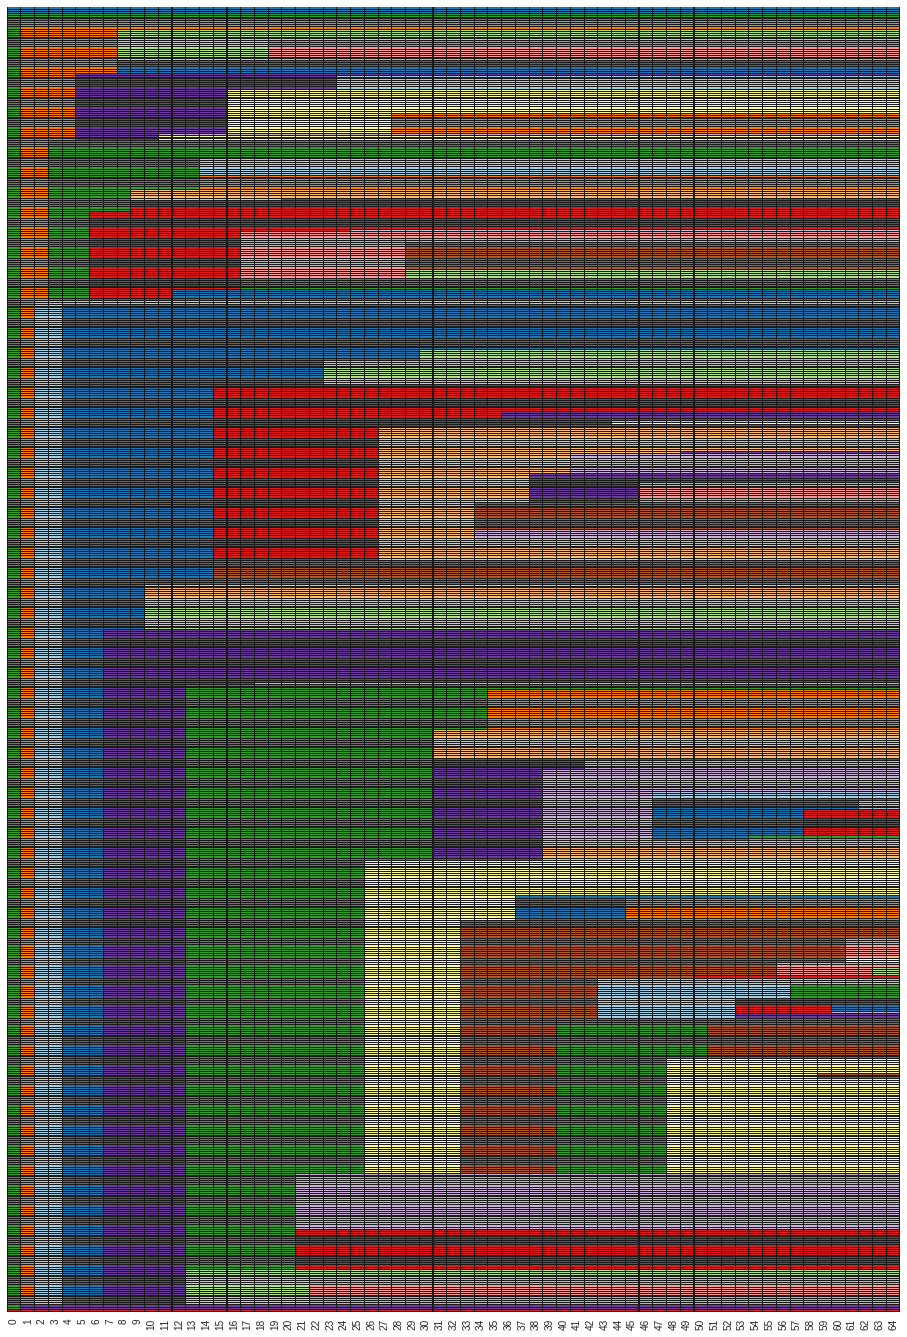

In [169]:
sns.set(style="white")

f, ax = plt.subplots()

# Draw the heatmap using seaborn
colors = sns.color_palette("Paired", n_colors=h2.max())
main = [1,3,5,7,9] # "Paired"
#main = [0,1,2,3,4,5] # "bright"
#main = [0,1,]
nmain = [i for i in range(h2.max()) if i not in main]
col, ors = [colors[i] for i in main], [colors[j] for j in nmain]
numpy.random.shuffle(ors)
colors = col; colors.extend(ors)
numpy.random.shuffle
g = sns.heatmap(h2, 
                cmap=mpl.colors.ListedColormap(colors),
                linecolor='k', linewidths=0.1,
                ax=ax, cbar=False, annot=False,
                yticklabels=False,
                );
#g.set(yticks=[]);
g.figure.set_size_inches(16, 24);

In [189]:
gps = groups
c = 5
indxs = numpy.where(gps == c)[0]

grp_dids = [idmapper.revlu[i] for i in indxs]
print(len(grp_dids))

12


In [206]:
ddd = mysql_utils.query_docs_details(cur, grp_dids, 
                                     fields=['id', 'link', 'title', 'summary', 'published', 'rss_link'])

In [208]:
ddd[['id', 'link', 'title', 'summary']].head(15)

,id,link,title,summary
0,10442,http://www.bbc.co.uk/news/entertainment-arts-3...,Is Nicole Kidman too young to play this mum?,Nicole Kidman is in talks to play Aquaman's mu...
1,12015,http://www.bbc.co.uk/news/uk-politics-38840352,Did Diane Abbott have 'Brexit flu'?,The Shadow Health Secretary was absent from th...
2,13323,http://www.bbc.co.uk/news/world-australia-3883...,The last hanged man,"Australia's last hanging was 50 years ago, but..."
3,19868,http://www.ft.com/cms/s/0/222f074c-e899-11e6-8...,EU leaders urged ‘not to punish Brits’ over Br...,Commission vice-president says restraint in ta...
4,23922,http://www.ft.com/cms/s/0/b06ace70-e95b-11e6-8...,Southern agrees deal to end train drivers’ strike,Relief for commuters as Aslef settles long-run...
5,25834,http://www.ft.com/cms/s/0/ebc205bc-e945-11e6-9...,Why February will be a key month for dollar bulls,"After retreat in January, several key events c..."
6,29548,https://phys.org/news/2017-02-efficient-nano-l...,More efficient nano-LED opens door to faster m...,The electronic data connections within and bet...
7,30572,https://phys.org/news/2017-02-texas-votes-scie...,Texas votes to change science lessons challeng...,The Texas Board of Education has preliminarily...
8,30647,https://phys.org/news/2017-02-values-gap-workp...,'Values gap' in workplace can lead millennials...,Much has been made in popular culture about mi...
9,30721,https://phys.org/news/2017-02-yellowstone-irri...,Judge asked to lift hold on Yellowstone irriga...,U.S. government attorneys have asked a federal...


In [174]:
for s in ddd['title']:
    print(s)
    print('\n')

Is Nicole Kidman too young to play this mum?


Did Diane Abbott have 'Brexit flu'?


The last hanged man


EU leaders urged ‘not to punish Brits’ over Brexit


Southern agrees deal to end train drivers’ strike


Why February will be a key month for dollar bulls


More efficient nano-LED opens door to faster microchips


Texas votes to change science lessons challenging evolution


'Values gap' in workplace can lead millennials to look elsewhere


Judge asked to lift hold on Yellowstone irrigation dam


Bank of England faces fresh embarrassment as tears up its forecasts | Larry Elliott


Southern rail and union agree deal to end strikes over driver-only trains




In [175]:
for s in ddd['summary']:
    print(s)
    print('\n')

Nicole Kidman is in talks to play Aquaman's mum in the next superhero film - but she is only 12 years older than the actor cast to play her son.


The Shadow Health Secretary was absent from the parliamentary vote on the Brexit bill.


Australia's last hanging was 50 years ago, but debate over the death penalty has often returned.


Commission vice-president says restraint in talks will help member states’ economies


Relief for commuters as Aslef settles long-running dispute over expanded role for drivers


After retreat in January, several key events could reignite a dollar rally


The electronic data connections within and between microchips are increasingly becoming a bottleneck in the exponential growth of data traffic worldwide. Optical connections are the obvious successors but optical data transmission requires an adequate nanoscale light source, and this has been lacking. Scientists at Eindhoven University of Technology (TU/e) now have created a light source that has the right

In [158]:
out = events_merge.process_timeslice_v2(ddd[['link', 'title', 'summary']])

In [159]:
ts_ = out['summary']['tslice']

In [160]:
mat = scipy.sparse.coo_matrix((ts_['vals'], ts_['ij']))

In [162]:
mat.sum(axis=1)

matrix([[  7.69725273],
        [  5.51927922],
        [  6.71419242],
        [  4.98525604],
        [  7.63691678],
        [  3.51965667],
        [  6.56252049],
        [  8.24870465],
        [  3.92324275],
        [  4.16908181],
        [  4.74270314],
        [  9.79989063],
        [ 17.88542756],
        [  9.65094975],
        [ 15.08830254],
        [ 10.91022352],
        [ 11.34627489],
        [ 18.55333603],
        [  8.72718504],
        [  8.28417303],
        [  7.62941167],
        [ 13.21110938],
        [ 22.24022275],
        [  6.52589763],
        [ 17.83285573],
        [ 19.15836876],
        [ 16.15503395],
        [ 10.92211227],
        [ 14.45079314],
        [ 13.62886865],
        [  7.86630142],
        [ 12.61102865],
        [ 13.77949277],
        [ 13.46306628],
        [ 17.2242445 ],
        [ 15.55207884],
        [ 11.18754063],
        [ 11.47413035],
        [ 16.04446049],
        [  5.97305772],
        [ 18.48708712],
        [ 14.821